Best Random Forest params: {'max_depth': 10, 'n_estimators': 200}


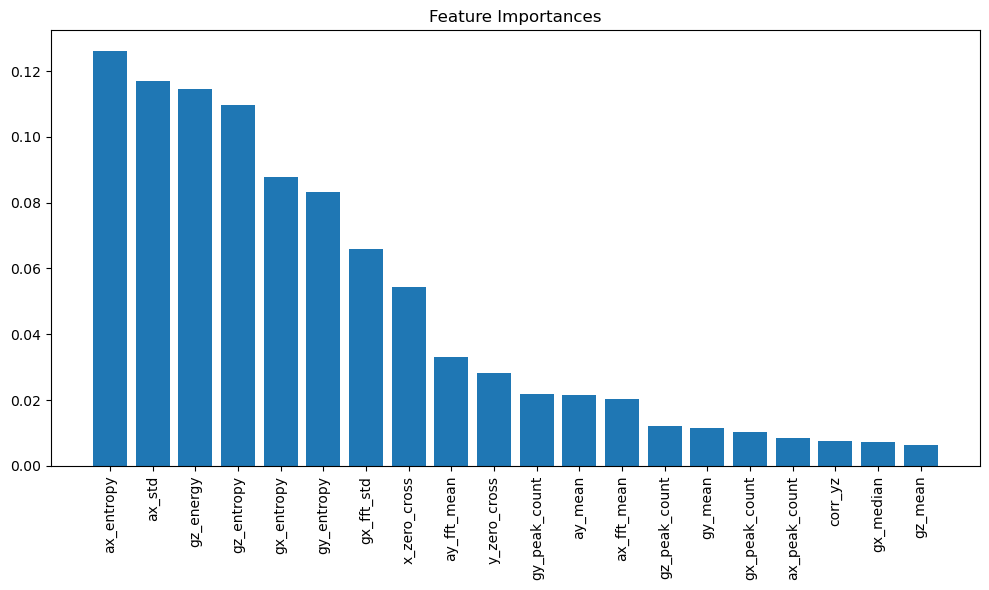

In [ ]:
import sys
sys.path.append('C:/Users/carlo/Desktop/Tesis/Github/Predicciones_ML')

import pandas as pd
import numpy as np
from src.preprocessing_blind import calcular_static_dynamic, encode_labels
from src.features_blind import create_windows, create_windows_blind, compute_features
from src.modeling_blind import remove_correlated_features, tune_logistic_regression, tune_random_forest, tune_svm, tune_xgb, tune_voting, smote
from src.visualization_blind import plot_confusion_matrix, plot_feature_importance
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data loading and preprocessing
data_train = pd.read_csv('C:/Users/carlo/Desktop/Tesis/Github/Predicciones_ML/data/Archivos_CSV_con_etiquetas/Mix_campana_sincopula.csv')
data_test = pd.read_csv('C:/Users/carlo/Desktop/Tesis/Github/Predicciones_ML/data/Archivos_CSV_sin_etiquetas/20-11-2025_T405_T3_date_OK.csv')
data_train['dateTime_UTC'] = pd.to_datetime(data_train['dateTime_UTC'], errors='coerce')
data_test['dateTime_UTC'] = pd.to_datetime(data_test['dateTime_UTC'], errors='coerce')
df_train = data_train[data_train['dateTime_UTC'].notna()]
df_test = data_test[data_test['dateTime_UTC'].notna()]
df_train = df_train.sort_values(by=['dateTime_UTC'], ignore_index=True)
df_test = df_test.sort_values(by=['dateTime_UTC'], ignore_index=True)

# Windowing and feature extraction
window_size = 50
step_size = window_size//2
x_list_train, y_list_train, z_list_train, gx_list_train, gy_list_train, gz_list_train, train_labels = create_windows(df_train, window_size, step_size)
x_df_train = pd.DataFrame(x_list_train)
y_df_train = pd.DataFrame(y_list_train)
z_df_train = pd.DataFrame(z_list_train)
gx_df_train = pd.DataFrame(gx_list_train)
gy_df_train = pd.DataFrame(gy_list_train)
gz_df_train = pd.DataFrame(gz_list_train)
X_train = compute_features(x_df_train, y_df_train, z_df_train, gx_df_train, gy_df_train, gz_df_train, window_size)

x_list_test, y_list_test, z_list_test, gx_list_test, gy_list_test, gz_list_test = create_windows_blind(df_test, window_size, step_size)
x_df_test = pd.DataFrame(x_list_test)
y_df_test = pd.DataFrame(y_list_test)
z_df_test = pd.DataFrame(z_list_test)
gx_df_test = pd.DataFrame(gx_list_test)
gy_df_test = pd.DataFrame(gy_list_test)
gz_df_test = pd.DataFrame(gz_list_test)
X_test = compute_features(x_df_test, y_df_test, z_df_test, gx_df_test, gy_df_test, gz_df_test, window_size)

# Label encoding
diccionario_codificacion = {'Quieta': 0, 'Caminando': 1, 'Comiendo': 2}
train_labels = encode_labels(train_labels, diccionario_codificacion)

# Feature selection (remove correlated features)
X_train_reduced, X_test_reduced, to_drop = remove_correlated_features(X_train, X_test, threshold=0.9)
# print(f"Features eliminadas por correlación > 0.9:\n{to_drop}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# #SMOTE (balancing the dataset)
# X_train_scaled, train_labels = smote(X_train_scaled, train_labels)

# Model training and hyperparameter tuning
# lr_best, lr_params = tune_logistic_regression(X_train_scaled, train_labels)
rf_best, rf_params = tune_random_forest(X_train_scaled, train_labels)
# svm_best, svm_params = tune_svm(X_train_scaled, train_labels)
# xgb_best, xgb_params = tune_xgb(X_train_scaled, train_labels)
# voting_clf= tune_voting(X_train_scaled, train_labels, base_models={'lr': lr_best, 'rf': rf_best, 'svm': svm_best, 'xgb': xgb_best})

# print("Best Logistic Regression params:", lr_params)
print("Best Random Forest params:", rf_params)
# print("Best SVM params:", svm_params)
# print("Best XGB params:", xgb_params)

# Evaluation
# pred_lr = lr_best.predict(X_test_scaled)
pred_rf = rf_best.predict(X_test_scaled)
# pred_svm = svm_best.predict(X_test_scaled)
# pred_xgb = xgb_best.predict(X_test_scaled)
# pred_voting = voting_clf.predict(X_test_scaled)
# Guardar las predicciones de Random Forest
pd.DataFrame(pred_rf, columns=['pred_rf']).to_csv('pred_rf_T405.csv', index=False)


plot_feature_importance(rf_best, X_train_reduced.columns)